In [1]:
!pip install natasha
!pip install -U bertopic
!pip install bertopic[visualization] sentence-transformers
!pip install g4f

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 51.0 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=12282567d985dd2174b785016823903e2db6220130850df6a3361fc24c4473dc
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26097 sha256=f22e441c1237e1f1c5abe06785559286bfff82f6ac49dfa551ee1e6b6d5a3722
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
Successfully built docopt intervaltree
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from transformers import pipeline
from transformers import AutoModelForSequenceClassification
from transformers import BertTokenizerFast

import torch
import torch.nn.functional as F
from torch import nn
from transformers import DataCollatorWithPadding

import pandas as pd
import numpy as np
from tqdm import tqdm
import json

from gensim.models import Word2Vec
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from nltk.tokenize import word_tokenize
import nltk
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer

from natasha import (
    Segmenter,
    MorphVocab,
    NewsEmbedding,
    NewsNERTagger,
    Doc
)

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from scipy.stats import shapiro, levene, ttest_ind
from datetime import datetime, timedelta

import logging
from g4f.client import Client

import time

In [3]:
df = pd.read_csv("comments.csv")
df['publishedAt'] = pd.to_datetime(df['publishedAt'])
logging.basicConfig(level=logging.INFO)

df.head(3)

,authorDisplayName,authorProfileImageUrl,authorChannelUrl,authorChannelIdValue,textDisplay,textOriginal,parentId,canRate,viewerRating,likeCount,publishedAt,updatedAt,video_id
0,@АннаСтарченко-ж1ъ,https://yt3.ggpht.com/ytc/AIdro_m40uRQD0SxNcc-...,http://www.youtube.com/@%D0%90%D0%BD%D0%BD%D0%...,UCMg02x4OLw7RahqREHJuwWg,Теперь мне жалко макрофагов:с,Теперь мне жалко макрофагов:с,NaN,True,none,0,2024-10-29 11:40:02+00:00,2024-10-29T11:40:02Z,o4nxYwym_4E
1,@ЕгорАгапитов-г3ц,https://yt3.ggpht.com/ytc/AIdro_lhWMxx2fFqOSRB...,http://www.youtube.com/@%D0%95%D0%B3%D0%BE%D1%...,UCOyKKleAvD4xSm_Mybfi_dA,Похуй у меня нет этого дерьмо,Похуй у меня нет этого дерьмо,NaN,True,none,0,2024-10-29 08:58:04+00:00,2024-10-29T08:58:04Z,o4nxYwym_4E
2,@pablusmercy1627,https://yt3.ggpht.com/ytc/AIdro_m_G9_jZ09w8Gn0...,http://www.youtube.com/@pablusmercy1627,UC2LRy5SPEyUfKBtDzoWU_KA,Жалко этих добряков,Жалко этих добряков,NaN,True,none,0,2024-10-29 06:12:08+00:00,2024-10-29T06:12:08Z,o4nxYwym_4E


# Sentiment analysis

In [15]:
tokenizer = BertTokenizerFast.from_pretrained('blanchefort/rubert-base-cased-sentiment-rusentiment')
model = AutoModelForSequenceClassification.from_pretrained('blanchefort/rubert-base-cased-sentiment-rusentiment', return_dict=True)

In [20]:
def process_sentiment_analysis(texts, model, batch_size=16, device='cpu') -> np.array:
    """
    Perform sentiment analysis on a list of text inputs using a given model.

    :param texts: List of strings to analyze.
    :param model: Pretrained model for sentiment analysis (e.g., Hugging Face transformer).
    :param batch_size: Number of texts to process in a single batch. Default is 16.
    :param device: Device to use for model inference ('cpu' or 'cuda'). Default is 'cpu'.
    :return: Numpy array of predicted sentiment classes for each text (e.g., 0: neutral, 1: positive, 2: negative).
    """
    sentiments = []
    model = model.to(device)

    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size)):
            batch = texts[i:i+batch_size]
            try:
                inputs = tokenizer(batch, max_length=512, padding=True, truncation=True, return_tensors='pt').to(device)
            except:
                logging.info(f"batch inference failed on {i} batch.")
                logging.info(f"{batch}")
                break
            outputs = model(**inputs)
            predicted = torch.nn.functional.softmax(outputs.logits, dim=1)
            predicted = torch.argmax(predicted, dim=1).cpu().numpy()
            sentiments.append(predicted)

    sentiments = np.concatenate(sentiments)

    return sentiments


def sentiment_analytics(sentiments, video_id, timestamp=''):
    """
    Calculate sentiment statistics for a given array of sentiment predictions.

    :param sentiments: Numpy array of sentiment predictions (0: neutral, 1: positive, 2: negative).
    :param timestamp: Optional timestamp for the analysis. Default is an empty string.
    :return: Dictionary containing sentiment counts, percentages, a proportion metric, and the timestamp.
    """
    answer = {}

    mask_positive = sentiments == 1
    mask_negative = sentiments == 2
    mask_neutral = sentiments == 0

    cnt_positive = np.sum(mask_positive)
    cnt_negative = np.sum(mask_negative)
    cnt_neutral = np.sum(mask_neutral)

    cnt_comments = cnt_positive + cnt_negative + cnt_neutral

    answer['positive'] = cnt_positive
    answer['negative'] = cnt_negative
    answer['neutral'] = cnt_neutral
    answer['positive_perc'] = (100 * cnt_positive / cnt_comments)
    answer['negative_perc'] = (100 * cnt_negative / cnt_comments)
    answer['neutral_perc'] = (100 * cnt_neutral / cnt_comments)
    answer['proportion_metric'] = np.mean(sentiments)
    answer['timestamp'] = timestamp
    answer['video_id'] = video_id

    logging.info(f"Sentiment analytics done successfully.")

    return answer


def plot_dynamics_video_to_video(values, title="Динамика значений",
                  xlabel="Видео", ylabel="Значение"):
    """
    Plot the dynamics of positive, negative, and neutral percentages across videos.

    :param values: list of dict
        A list of dictionaries containing statistics for each video.
        Each dictionary should have keys: 'video_id', 'positive_perc', 'negative_perc', and 'neutral_perc'.
    :param title: str, optional
        Title of the plot (default is "Динамика значений").
    :param xlabel: str, optional
        Label for the x-axis (default is "Видео").
    :param ylabel: str, optional
        Label for the y-axis (default is "Значение").
    :raises ValueError:
        If either the positive or negative value lists are empty.
    :return: None
    """

    videos = [stat['video_id'] for stat in values]
    values1 = [stat['positive_perc'] for stat in values]
    values2 = [stat['negative_perc'] for stat in values]
    values3 = [stat['neutral_perc'] for stat in values]
    label1 = 'Процент позитивных комментариев'
    label2 = 'Процент негативных комментариев'
    label3 = 'Процент нейтральных комментариев'

    if not values1 or not values2:
        logging.info(f"Plotting dynamics requires non-empty values.")
        raise ValueError("Оба списка значений не должны быть пустыми.")

    plt.figure(figsize=(10, 6))
    plt.plot(videos, values1, marker='o', linestyle='-', color='b', label=label1)
    plt.plot(videos, values2, marker='s', linestyle='--', color='r', label=label2)

    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gcf().autofmt_xdate(rotation=60, ha='right')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()

    plt.savefig("video_to_video.png", format='png', dpi=300)
    plt.show()

    logging.info(f".png file has been saved.")

    plt.close()


def plot_dynamics_in_video(values, title="Динамика значений",
                  xlabel="Дата и время", ylabel="Значение"):
    """
    Plot sentiment dynamics over time.

    :param values: List of dictionaries containing timestamps and sentiment percentages
                   (keys: 'timestamp', 'positive_perc', 'negative_perc', 'neutral_perc').
    :param title: Title of the plot. Default is "Динамика значений".
    :param xlabel: Label for the X-axis. Default is "Дата и время".
    :param ylabel: Label for the Y-axis. Default is "Значение".
    :return: None. Displays the plot.
    """

    dates = [stat['timestamp'] for stat in values]
    values1 = [stat['positive_perc'] for stat in values]
    values2 = [stat['negative_perc'] for stat in values]
    values3 = [stat['neutral_perc'] for stat in values]
    label1 = 'Процент позитивных комментариев'
    label2 = 'Процент негативных комментариев'
    label3 = 'Процент нейтральных комментариев'

    if not values1 or not values2:
        logging.info(f"Plotting dynamics requires non-empty values.")
        raise ValueError("Оба списка значений не должны быть пустыми.")

    plt.figure(figsize=(10, 6))
    plt.plot(dates, values1, marker='o', linestyle='-', color='b', label=label1)
    plt.plot(dates, values2, marker='s', linestyle='--', color='r', label=label2)
    # plt.plot(dates, values3, marker='s', linestyle='-.', color='grey', alpha=0.5, label=label3)

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gcf().autofmt_xdate(rotation=60, ha='right')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()

    plt.savefig("in_video.png", format='png', dpi=300)
    plt.show()

    logging.info(f".png file has been saved.")

    plt.close()


def normal_dist_test(sample: np.array) -> bool:
    """
    Test whether a given sample follows a normal distribution.

    :param sample: Numpy array of sample values.
    :return: True if the sample follows a normal distribution, False otherwise.
    """
    mean_sample = []
    for i in range(500):
        subsample = np.random.choice(sample, size=100)
        mean_sample.append(np.mean(subsample))

    mean_sample = np.array(mean_sample)
    result = shapiro(mean_sample).statistic

    if result > 0.05:
        logging.info(f"Normal distribution")
        return True

    logging.warning(f"NOT normal distribution!")
    return False


def var_equality_test(sample1: np.array, sample2: np.array) -> bool:
    """
    Test whether two samples have equal variance.

    :param sample1: First numpy array of sample values.
    :param sample2: Second numpy array of sample values.
    :return: True if the variances are equal, False otherwise.
    """
    result = levene(sample1, sample2).statistic

    if result > 0.05:
        logging.info(f"Vars are same.")
        return True

    logging.warning(f"Vars are different!")
    return False


def are_emotions_same(s1: np.array, s2: np.array) -> bool:
    """
    Determine if two sentiment samples are statistically similar using hypothesis testing.

    :param s1: First numpy array of sentiment predictions.
    :param s2: Second numpy array of sentiment predictions.
    :return: True if the sentiment distributions are statistically similar, False otherwise.
    """
    sz = np.min([len(s1), len(s2)])
    sample1 = np.random.choice(s1, size=sz)
    sample2 = np.random.choice(s2, size=sz)

    if not normal_dist_test(sample1) or not normal_dist_test(sample2):
        print('not normal distribution')
        return False

    result = ttest_ind(sample1, sample2, equal_var=var_equality_test(sample1, sample2)).pvalue

    print(f't-test pvalue: {result}')

    if result > 0.05:
        logging.info(f"Same emotions")
        return True

    logging.info(f"NOT same emotions")
    return False


def get_emotional_dynamics_video_to_video(videos, df, model, device):
    answer = []

    for video_id in videos:
        sample = df[df['video_id'] == video_id]
        result = process_sentiment_analysis(sample['textDisplay'].fillna('').values.tolist(), model, device=device)
        analytics = sentiment_analytics(result, video_id)
        answer.append(analytics)

    logging.info(f"Emotional dynamics video to video has been collected.")

    return answer


def get_emotional_dynamics_in_video(video_id, df, start, end, model, device, detailing='h'):
    """
    Analyze the emotional dynamics of comments for a specific video within a time range.

    :param video_id: ID of the video to analyze.
    :param df: DataFrame containing comments data with 'video_id' and 'publishedAt' columns.
    :param start: Start time (datetime object) for the analysis.
    :param end: End time (datetime object) for the analysis.
    :param model: Pretrained model for sentiment analysis.
    :param device: Device for model inference ('cpu' or 'cuda').
    :param detailing: Granularity of the analysis ('m': minute, 'h': hour, 'd': day). Default is 'h'.
    :return: List of dictionaries containing sentiment analytics for each time interval.
    """
    sample = df[df['video_id'] == video_id]
    max_iter = 100
    comments = np.array([])
    answer = []

    iter = 0

    current_time = start
    while current_time <= end:
        prev_current_time = current_time
        if detailing == 'm':
            addition = sample[(sample.publishedAt >= current_time) & (sample.publishedAt < current_time + timedelta(minutes=1))]
            current_time += timedelta(minutes=1)
        elif detailing == 'h':
            addition = sample[(sample.publishedAt >= current_time) & (sample.publishedAt < current_time + timedelta(hours=1))]
            current_time += timedelta(hours=1)
        elif detailing == 'd':
            addition = sample[(sample.publishedAt >= current_time) & (sample.publishedAt < current_time + timedelta(days=1))]
            current_time += timedelta(days=1)

        if addition.empty:
            continue

        iter += 1

        result = process_sentiment_analysis(addition['textDisplay'].fillna('').values.tolist(), model, device=device)
        if (len(comments) == 0):
            comments = np.array(result)
        else:
            comments = np.concatenate((comments, result))

        analytics = sentiment_analytics(comments, video_id, prev_current_time)
        answer.append(analytics)

        if iter >= max_iter:
            print('Limit reached')
            break

    logging.info(f"Emotional dynamics within video has been collected.")
    return answer


In [17]:
# pipeline to plot dynamics video to video (dyn) and within video (dyn2)

texts = df['textDisplay'].fillna('').values.tolist()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

dyn = get_emotional_dynamics_video_to_video(df.video_id.unique(), df, model, device)

dyn2 = get_emotional_dynamics_in_video('o4nxYwym_4E', df, pd.Timestamp('2024-10-18', tz='UTC'), pd.Timestamp('2024-10-29', tz='UTC'), model, device, 'h')

100%|██████████| 177/177 [00:11<00:00, 14.98it/s]


100%|██████████| 1/1 [00:00<00:00, 42.49it/s]


Limit reached


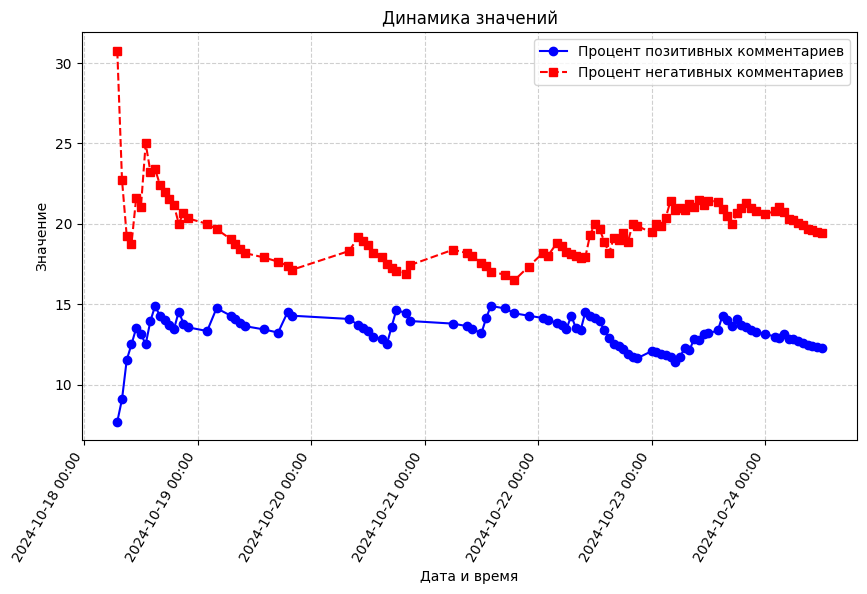

In [22]:
plot_dynamics_in_video(dyn2)

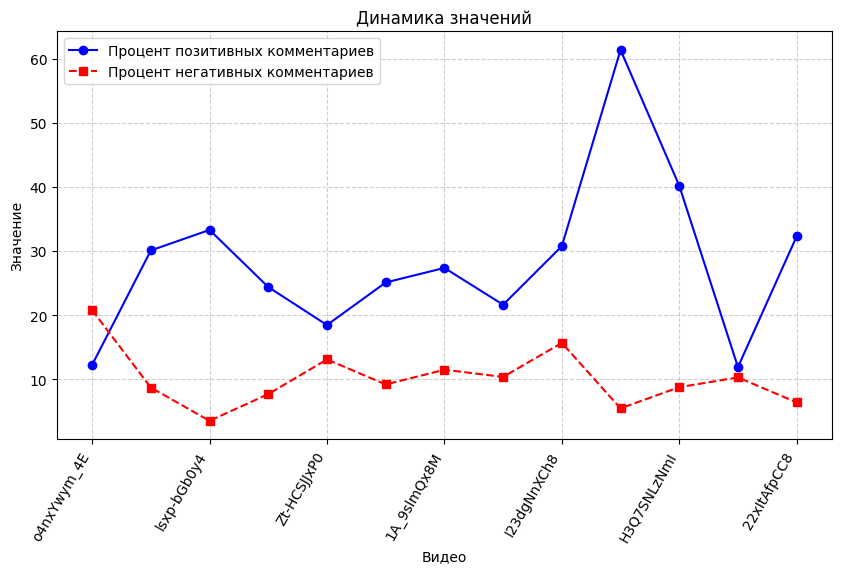

In [21]:
plot_dynamics_video_to_video(dyn)

In [23]:
# pipeline to compare sentiments in 2 videos

sentiments = process_sentiment_analysis(texts, model, batch_size=16, device=device)

test1 = np.random.choice(sentiments, size=20)
test2 = np.random.choice(sentiments, size=400)

are_emotions_same(test1, test2)

100%|██████████| 6639/6639 [07:35<00:00, 14.57it/s]


t-test pvalue: 1.0


True

# Clustering

In [6]:
def comment_vector(tokens):
    """
    Generate a single vector representation of a comment using word embeddings.

    :param tokens: List of tokenized words from a comment.
    :return: Numpy array representing the mean vector of the tokens in the comment.
             Returns a zero vector if no tokens have embeddings in the model.
    """
    vectors = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
    if len(vectors) == 0:
        logging.warning(f"list of vectors is empty!")
        return np.zeros(w2v_model.vector_size)
    else:
        logging.info(f"vectors have been collected successfully.")
        return np.mean(vectors, axis=0)


def kmeans_clustering(df, comment_vectors, n_clusters=10, max_iter=300):
    """
    Perform KMeans clustering on comment vectors.

    :param df: DataFrame containing comments and additional metadata.
    :param comment_vectors: Numpy array of comment vector representations.
    :param n_clusters: Number of clusters to form. Default is 10.
    :param max_iter: Maximum number of iterations for the KMeans algorithm. Default is 300.
    :return: Trained KMeans object with cluster assignments.
    """
    scaler = StandardScaler()
    comment_vectors_scaled = scaler.fit_transform(comment_vectors)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, max_iter=max_iter).fit(comment_vectors_scaled)

    logging.info(f"Done KMeans.")

    return kmeans

In [48]:
class TopicModel:
    """
    A class for topic modeling using BERTopic with a multilingual sentence transformer.

    :param stop_words: list
        A list of stop words to exclude during vectorization.
    """
    def __init__(self, stop_words):
        """
        Initialize the TopicModel with the given stop words and pre-configured models.

        :param stop_words: list
            Stop words to exclude during topic modeling.
        """
        self.stop_words = stop_words
        self.sentence_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

        self.topic_model = BERTopic(
            embedding_model=self.sentence_model,
            vectorizer_model=CountVectorizer(ngram_range=(1, 2), stop_words=list(self.stop_words)),
            nr_topics=15,
            verbose=True
        )

    def forward(self, comments):
        """
        Fit and transform the comments into topics and probabilities.

        :param comments: list
            List of text comments.
        :return: tuple
            Topics and probabilities for each comment.
        """
        return self.topic_model.fit_transform(comments)


def get_bertopic_clusters(df, model: TopicModel):
    """
    Assign BERTopic clusters to a DataFrame and filter out insignificant clusters.

    :param df: pandas.DataFrame
        DataFrame containing a column 'textDisplay' with comments.
    :param model: TopicModel
        An instance of the TopicModel class.
    :return: pandas.DataFrame
        DataFrame with assigned cluster labels, filtered by significance.
    """
    comments = df['textDisplay'].fillna('').values.tolist()
    topics, probs = model.forward(comments)
    topic_model = model.topic_model
    topic_s = topic_model.get_topics()
    indeces = [k for k, v in topic_s.items()]

    df['cluster'] = topics
    df['topic_raw'] = topic_model.get_topic_info().Name

    good_clusters = []
    for i in range(len(indeces)):
        if 0.005 * len(df) < topic_model.get_topic_info().iloc[i].Count < 0.4 * len(df) and topic_model.get_topic_info().iloc[i].Count > 10: # and topic_coherence_scores[i] > 0.3
            good_clusters.append(indeces[i])

    logging.info(f"Collected good clusters for BERTopic")

    return df.isin({'cluster': good_clusters})


def get_kmeans_clusters(df):
    """
    Apply KMeans clustering to comments and filter out insignificant clusters.

    :param df: pandas.DataFrame
        DataFrame containing a column 'comment_vector' with precomputed vectors.
    :return: pandas.DataFrame
        DataFrame with filtered cluster labels added as 'cluster_km'.
    """
    comment_vectors = np.vstack(df['comment_vector'].values)
    kmeans = kmeans_clustering(df, comment_vectors, n_clusters=15, max_iter=300)

    clusters = kmeans.labels_
    df['cluster_km'] = clusters

    # print(len(clusters), clusters)

    good_clusters = []
    for i in range(len(df['cluster_km'].unique())):
        if 0.005 * len(df) < dict(df['cluster_km'].value_counts())[i] < 0.4 * len(df) and dict(df['cluster_km'].value_counts())[i] > 10: # and topic_coherence_scores[i] > 0.3
            good_clusters.append(i)

    logging.info(f"Collected good clusters for KMeans")

    return df[df['cluster_km'].isin(good_clusters)]


def title_clusters(df_bert, df_kmeans):
    """
    Generate titles for clusters using GPT model for both BERTopic and KMeans clusters.

    :param df_bert: pandas.DataFrame
        DataFrame with BERTopic clusters labeled.
    :param df_kmeans: pandas.DataFrame
        DataFrame with KMeans clusters labeled.
    :return: dict
        Dictionary mapping cluster titles to example comments.
    """
    answer = {}
    client = Client()

    for cluster_id in tqdm(df_kmeans['cluster_km'].unique()):
        km_i = df_kmeans[df_kmeans['cluster_km'] == cluster_id]['textDisplay'].head(10).to_list()

        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": f"Не отвечай ничего кроме названия кластера"},
                {"role": "user", "content": f"Дай название кластеру: {km_i}"}
            ],
        )
        time.sleep(8)
        title = (response.choices[0].message.content)

        answer[title] = (km_i, len(df_kmeans[df_kmeans['cluster_km'] == cluster_id]['textDisplay'].to_list()))

    logging.info(f"KMeans clusters have been titled successfully.")

    for cluster_id in tqdm(df_bert['cluster'].unique()):
        bert_i = df_bert[df_bert['cluster'] == cluster_id]['textDisplay'].head(10).to_list()

        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": f"Не отвечай ничего кроме названия кластера"},
                {"role": "user", "content": f"Дай название кластеру: {bert_i}"}
            ],
        )
        time.sleep(8)
        title = (response.choices[0].message.content)

        answer[title] = (bert_i, len(df_bert[df_bert['cluster'] == cluster_id]['textDisplay'].to_list()))

    logging.info(f"BERTopic clusters have been titled successfully.")

    if (len(answer) > 10):
        sorted_answer = dict(sorted(answer.items(), key=lambda item: item[1][1]))
        answer = dict(list(sorted_answer.items())[:10])

    return answer

In [8]:
nltk.download('punkt_tab')
df['tokens'] = df['textDisplay'].astype(str).apply(word_tokenize)
w2v_model = Word2Vec(sentences=df['tokens'], vector_size=100, window=5, min_count=2, sg=1)
df['comment_vector'] = df['tokens'].apply(comment_vector)

stop_words = np.loadtxt('stopwords-ru.txt', dtype=str, usecols=0)
model = TopicModel(stop_words)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [9]:
df_bert = get_bertopic_clusters(df, model)


2024-12-15 07:49:17,654 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/3320 [00:00<?, ?it/s]

2024-12-15 07:50:28,122 - BERTopic - Embedding - Completed ✓
2024-12-15 07:50:28,124 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-12-15 07:53:51,061 - BERTopic - Dimensionality - Completed ✓
2024-12-15 07:53:51,066 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-12-15 07:54:06,288 - BERTopic - Cluster - Completed ✓
2024-12-15 07:54:06,289 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-12-15 07:54:12,989 - BERTopic - Representation - Completed ✓
2024-12-15 07:54:13,008 - BERTopic - Topic reduction - Reducing number of topics
2024-12-15 07:54:18,935 - BERTopic - Topic reduction - Reduced number of topics from 1339 to 15


In [50]:
df_kmeans = get_kmeans_clusters(df)
titles = title_clusters(df_bert, df_kmeans)
titles

100%|██████████| 2/2 [00:26<00:00, 13.30s/it]


{'Топ борода': (['Борода тебе шла',
   'Минус борода',
   'эээ гдэ борода',
   'Где борода',
   'Тебе идет борода',
   'Борода была топ',
   'Где борода',
   'где борода',
   'Где борода',
   'норм борода'],
  1861),
 'Макрофаги <3': (['макрофаги <3',
   'Макрофаги >>> моралфаги',
   'Яну 37 лет 😮',
   '5 млн просмотров 😮😂',
   'Давайте еще 123',
   'Я думал прошло 10 минут а не 40',
   '❤ ти чуєш 80',
   '4 минуты просмотра и лайк',
   '1 курс меда🤪🤟',
   '<3<3<3'],
  1875),
 'Кластер: "Мазафаки и Макрофаги"': (['Ты кто воин? Я мазафаки😂',
   'О как😮, а я не знал😎',
   'Я в ахуе я сама тату мастер',
   'Я не верю.',
   'я реально охерел',
   'я сделаю тату',
   'Я в шоках просто😄',
   'Я архирел просто',
   'Я в ахюе',
   'Я зауважал макрофагов.и лазеру респект'],
  1881),
 '"Тату-Остаточные-Следствия"': (['Лица татуированных женщин представили?) когда спустя 5 лет у них начинаются лютые заболевания \n\n\nЗато с тату)))))',
   'Макрофаг ватофак)',
   '😅',
   'Набью еще 😊)',
   'У меня

# NER

In [ ]:
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
ner_tagger = NewsNERTagger(emb)


def filter_comments_with_entity(comments, target_entity):
    """
    Filter a list of comments to retain only those that mention a specific entity.

    :param comments: List of strings, where each string is a comment to analyze.
    :param target_entity: Target entity (normalized form) to search for in the comments.
    :return: List of filtered comments that mention the target entity.
    """
    filtered_comments = []

    for comment in tqdm(comments):
        doc = Doc(comment)
        doc.segment(segmenter)
        doc.tag_ner(ner_tagger)

        for span in doc.spans:
            span.normalize(morph_vocab)
            if span.normal == target_entity:
                filtered_comments.append(comment)
                break

    return filtered_comments

In [ ]:
texts = df['textDisplay'].fillna('').values.tolist()

filtered_comments = filter_comments_with_entity(texts, target_entity="Ян")
print(len(filtered_comments))
for i in range(3):
    print(filtered_comments[i])
    print()


100%|██████████| 106223/106223 [05:55<00:00, 299.03it/s]

0


IndexError: list index out of range